In [0]:
#basic packages
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

#scipy package 
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.spatial import distance_matrix
from scipy.signal import medfilt

#plot package
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd  '/content/drive/My Drive/Google-colab/ADBI-Project10-CNN'

/content/drive/My Drive/Google-colab/ADBI-Project10-CNN


In [0]:
#torch package
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [0]:
#building a fully connected graph 
#returns a matrix with coordinates(N,2) and matrix containing pairwise euclidean distances
def getGraph(n=10, size=1):
    generateRandomNumber = np.random.uniform(size=(n,2), high=10.0)
    coords = size * generateRandomNumber
    distMat = distance_matrix(coords, coords)
    return coords, distMat

In [0]:
#plot the fully connected graph
def plotGraph(coords, mat):
    n = len(coords)
    arr = []
    for _ in range(n):
      arr.append(50)

    plt.scatter(coords[:,0], coords[:,1], arr,'g')
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.8)

In [0]:
#input : state (graph and visited nodes)
#output : vector of size N containing Q(s, a) for each of the N actions a
class QNet(nn.Module):
#embDim: embedding dimension p
#T : number of iterations for the graph embedding

    def __init__(self, embDim, T=4):
        super(QNet, self).__init__()
        self.embDim = embDim
        self.T = T
        
        # We use 5 dimensions for representing the nodes states:
        self.node_dim = 5
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.embDim, True)
        self.theta2 = nn.Linear(self.embDim, self.embDim, True)
        self.theta3 = nn.Linear(self.embDim, self.embDim, True)
        self.theta4 = nn.Linear(1, self.embDim, True)
        self.theta5 = nn.Linear(2*self.embDim, 1, True)
        self.theta6 = nn.Linear(self.embDim, self.embDim, True)
        self.theta7 = nn.Linear(self.embDim, self.embDim, True)

        self.theta1Extras = []
        for _ in range(nr_extra_layers_1):
          self.theta1Extras.append(nn.Linear(self.embDim, self.embDim, True))

    def forward(self, xv, Ws):
        # xv: The node features (batch_size, numNodes, node_dim)
        # Ws: The graphs (batch_size, numNodes, numNodes)
        
        numNodes = xv.shape[1]
        batchSize = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, numNodes, numNodes)
        connMatrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batchSize, numNodes, self.embDim, device=device)
       
        # (batchSize, numNodes, embDim)
        s1 = self.theta1(xv)  

        for layer in self.theta1Extras:
        # we apply the extra layer
            s1 = layer(F.relu(s1))  
        
        # (batchSize, nr_nodes, nr_nodes, embDim) - each "weigth" is a p-dim vector
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))     
        # (batchSize, nr_nodes, embDim) - the embedding for each node     
        s3_2 = torch.sum(s3_1, dim=1)  
        # (batchSize, nr_nodes, embDim)
        s3 = self.theta3(s3_2) 
        
        for t in range(self.T):
            temp = connMatrices.matmul(mu)
            s2 = self.theta2(temp)    
            mu = F.relu(s1 + s2 + s3)
            
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        globalState = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, numNodes, 1))
        
        # (batch_dim, nr_nodes, embDim)
        localAction = self.theta7(mu)  

        return self.theta5(F.relu(torch.cat([globalState, localAction], dim=2))).squeeze(dim=2)

In [0]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  
        self.lr_scheduler = lr_scheduler
        self.lossFn = nn.MSELoss()
        self.optimizer = optimizer

    #best (greedy) action to take from a given state
    #returns : tuple containing the ID of the next node and the corresponding estimated reward    
    def bestAction(self, stateTsr, state):
        W = state.W
        estimatedRewards = self.predict(stateTsr, W)  # size (nr_nodes)
        sorted_reward_idx = estimatedRewards.argsort(descending=True)
        solution = state.partial_solution
        alreadyIn = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) :
              if(idx not in alreadyIn):
                return idx, estimatedRewards[idx].item()

    def predict(self, stateTsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimatedRewards = self.model(stateTsr.unsqueeze(0), W.unsqueeze(0))
        return estimatedRewards[0]
 
    
    #states_tsrs: list of (single) state tensors
    #Ws: list of W tensors
    #actions: list of actions taken
    #targets: list of targets (resulting estimated rewards after taking the actions)
    def batchUpdate(self, states_tsrs, Ws, actions, targets):       
        WsTsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        lenActions = len(actions)
        estimatedRewards = self.model(xv, WsTsr)[range(lenActions), actions]
        
        loss = self.lossFn(estimatedRewards, torch.tensor(targets, device=device))
        lossVal = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return lossVal 



    


In [0]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'stateTsr', 'action', 'reward', 'next_state', 'next_stateTsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience

        self.position = (self.position + 1) % self.capacity
        self.nr_inserts = self.nr_inserts + 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

In [0]:
def totalDistance(solution, W):
    lenOfSol = len(solution)
    if lenOfSol < 2:
        return 0  # there is no travel
    
    totalDist = 0
    for i in range(lenOfSol - 1):
        totalDist = totalDist + W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if lenOfSol == W.shape[0]:
        totalDist = totalDist + W[solution[-1], solution[0]].item()

    return totalDist

In [0]:
def checkFinalState (state):
    if len(set(state.partial_solution)) == state.W.shape[0]:
      return 1 
    else:
      return 0

In [0]:
def generateNeighbour(state):
    solution  = state.partial_solution
    W = state.W
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))

    alreadyIn = set(solution)
    candidates = list(filter(lambda n: n.item() not in alreadyIn, W[solution[-1]].nonzero()))

    if len(candidates) == 0:
        return None

    return random.choice(candidates).item()

In [0]:
def init_model(fname=None):

    #Create a new model. If fname is defined, load the model from the specified file.
    #EMBEDDING_ITERATIONS_T = 1  
    #EMBEDDING_DIMENSIONS = 5 
    Q_net = QNet(5, T=1).to(device)
    #INIT_LR = 5e-3
    optimizer = optim.Adam(Q_net.parameters(), lr=5e-3)
    LR_DECAY_RATE = 1.- 2e-5  
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

In [0]:
def checkpoint_model(model, optimizer, lr_scheduler, loss, episode, avg_length):
    FOLDER_NAME = './models'  
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

In [0]:
#function to track the history of visisted nodes 
#returns a tensor, where for each node we store whether this node is in the sequence, whether it is first or last, and its (x,y) coordinates
def state2tens(state):

    solution = set(state.partial_solution)
    if len(state.partial_solution) > 0:
      solLastNode = state.partial_solution[-1]
    else: 
      solLastNode = -1

    if len(state.partial_solution) > 0:
      solFirstNode = state.partial_solution[0]
    else: 
      solFirstNode = -1

    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == solFirstNode else 0),
           (1 if i == solLastNode else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

In [0]:
def _moving_avg(x, N=10):
    res = np.convolve(np.array(x), np.ones((N,))/N, mode='valid')
    return res

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
coords, W_np = getGraph(n=10)

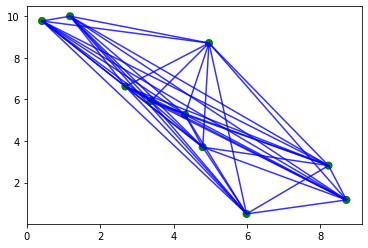

In [0]:
plotGraph(coords, W_np)

In [0]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))

In [0]:
#model returns
model = QNet(3, T=1).to(device)
coords, W_np = getGraph(n=10)
W = torch.tensor(W_np, dtype=torch.float32, device=device)

# random node state
ws = W.unsqueeze(0)
xv = torch.rand((1, W.shape[0], 5)).to(device) 

y = model(xv, ws)
print('model output: {}'.format(y))

model output: tensor([[20.7292, 20.7529, 20.5422, 20.7566, 21.0996, 20.5961, 20.5498, 21.2406,
         20.5488, 21.0940]], grad_fn=<SqueezeBackward1>)


In [0]:
# seed everything for reproducible results first:
#SEED = 1
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [0]:
# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

In [0]:
# Create memory
#MEMORY_CAPACITY = 10000
memory = Memory(10000)

In [0]:
# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

In [0]:
#NR_EPISODES = 4001
NR_NODES = 10 
foundSolutions = dict() 
losses = [] 
path_lengths = []
for episode in range(3000):
    # sample a new random graph
    coords, W_np = getGraph(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]
    
    # current state (tuple and tensor)
    currentState = State(partial_solution=solution, W=W, coords=coords)
    currentStateTsr = state2tens(currentState)
    
    # Keep track of some variables for insertion in replay memory:
    states = [currentState]
    states_tsrs = [currentStateTsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(0.1, (1-6e-4)**episode)
    
    nr_explores = 0
    t = -1
    while not checkFinalState(currentState):
        t = t + 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = generateNeighbour(currentState)
            nr_explores = nr_explores + 1
        else:
            # exploit
            next_node, est_reward = Q_func.bestAction(currentStateTsr, currentState)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        
        # reward observed for taking this step        
        reward = -(totalDistance(next_solution, W) - totalDistance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_stateTsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_stateTsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        N_STEP_QL = 2 
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       stateTsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_stateTsr=next_stateTsr))
            
        if checkFinalState(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           stateTsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_stateTsr=next_stateTsr))
        
        # update state and current solution
        currentState = next_state
        currentStateTsr = next_stateTsr
        solution = next_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= 16 and len(memory) >= 2000:
            experiences = memory.sample_batch(16)

            batch_states_tsrs = []
            batch_Ws = []
            batch_actions = []
            batch_targets = []

            for e in experiences:
              batch_states_tsrs.append(e.stateTsr)
              batch_Ws.append(e.state.W)
              batch_actions.append(e.action)

            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not checkFinalState(experience.next_state):
                    _, best_reward = Q_func.bestAction(experience.next_stateTsr, 
                                                            experience.next_state)
                    GAMMA = 0.9
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batchUpdate(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            
            #Save model when we reach a new low average path length
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = totalDistance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        foundSolutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 34.873 / last = 34.8726 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 57.169 / last = 57.1693 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 49.743 / last = 43.1855 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 49.743 / last = 37.4273 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 49.743 / last = 50.7731 / epsilon = 0.9763 / lr = 0.0050
Ep 50 | current sol: [8, 5] / next est reward: -2.981745481491089
Ep 50 | current sol: [8, 5, 7, 4] / next est reward: -2.9820759296417236
Ep 50. Loss = -1.000 / median length = 50.003 / last = 53.9514 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 51.021 / last = 61.1923 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 52.485 / last = 55.1055 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 52.705 / last = 61.8595 / epsilon = 0.9531 / lr = 0.005

Text(0.5, 0, 'Episode')

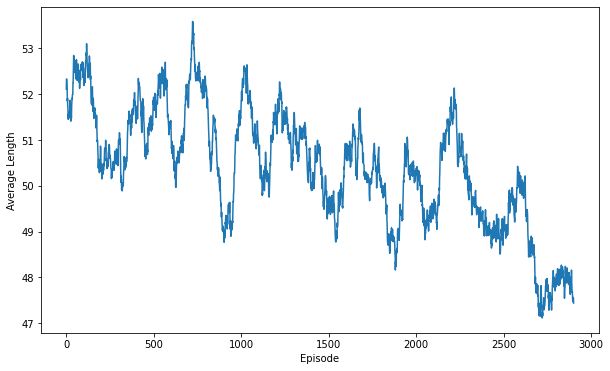

In [0]:
plt.figure(figsize=(10,6))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('Average Length')
plt.xlabel('Episode')

Text(0.5, 0, 'Training Iteration')

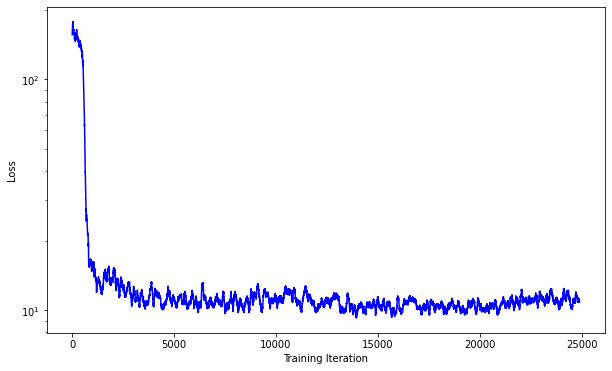

In [0]:
plt.figure(figsize=(10,6))

plt.semilogy(_moving_avg(losses, 100),color='blue')
plt.ylabel('Loss')
plt.xlabel('Training Iteration')

In [0]:
from __future__ import print_function
import math
!pip install -q ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [0]:
#Get file with smallest distance
FOLDER_NAME = './models'
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

shortest avg length found: 44.34143650531769


In [0]:
# Load checkpoint
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

In [0]:
#A function to plot solutions
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i = solution[idx]
        next_i = solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8,color='blue')
    
    i = solution[-1]
    next_i = solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8,color='blue')
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10,color='brown')

In [0]:
from __future__ import print_function
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def create_data_model(W):
  """Stores the data for the problem."""
  data = {}
  # Locations in block units
  data['locations'] = W.tolist()
  data['num_vehicles'] = 1
  data['depot'] = 0
  return data

def compute_euclidean_distance_matrix(locations):
  """Creates callback to return distance between points."""
  distances = {}
  for from_counter, from_node in enumerate(locations):
      distances[from_counter] = {}
      for to_counter, to_node in enumerate(locations):
          if from_counter == to_counter:
              distances[from_counter][to_counter] = 0
          else:
              # Euclidean distance
              distances[from_counter][to_counter] = (int(
                  math.hypot((from_node[0] - to_node[0]),
                              (from_node[1] - to_node[1]))))
  return distances

def print_solution(manager, routing, solution):
  """Prints solution on console."""
  print('Objective: {}'.format(solution.ObjectiveValue()))
  index = routing.Start(0)
  plan_output = 'Route:\n'
  route_distance = 0
  while not routing.IsEnd(index):
      plan_output += ' {} ->'.format(manager.IndexToNode(index))
      previous_index = index
      index = solution.Value(routing.NextVar(index))
      route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
  plan_output += ' {}\n'.format(manager.IndexToNode(index))
  print(plan_output)
  plan_output += 'Objective: {}m\n'.format(route_distance)

def googleORtools(W_np):
  # Instantiate the data problem.
  data = create_data_model(W_np)

  # Create the routing index manager.
  manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                          data['num_vehicles'], data['depot'])

  # Create Routing Model.
  routing = pywrapcp.RoutingModel(manager)

  distance_matrix = compute_euclidean_distance_matrix(data['locations'])

  def distance_callback(from_index, to_index):
      """Returns the distance between the two nodes."""
      # Convert from routing variable Index to distance matrix NodeIndex.
      from_node = manager.IndexToNode(from_index)
      to_node = manager.IndexToNode(to_index)
      return distance_matrix[from_node][to_node]

  transit_callback_index = routing.RegisterTransitCallback(distance_callback)

  # Define cost of each arc.
  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

  # Setting first solution heuristic.
  search_parameters = pywrapcp.DefaultRoutingSearchParameters()
  search_parameters.first_solution_strategy = (
      routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

  # Solve the problem.
  solution = routing.SolveWithParameters(search_parameters)

  # Print solution on console.
  if solution:
      print_solution(manager, routing, solution)


In [0]:
!pip install ortools

     |████████████████████████████████| 28.9MB 139kB/s 
     |████████████████████████████████| 1.3MB 41.0MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [0]:
# import util
import numpy as np
import math

def check_unvisited_node(unvisited):
    for u in unvisited:
        if u == 1:
            return True
    return False

def find_best_route(node_no, travel_route, min_distance):
    shortest_travel_route = travel_route[0]
    shortest_min_distance = min_distance.item(0)
    for start_node in range(0, node_no):
        if min_distance[start_node] < shortest_min_distance:
            shortest_min_distance = min_distance.item(start_node)
            shortest_travel_route = travel_route[start_node]

    # print("min distance is: " + str(shortest_min_distance))
    # print("travel route is: ")
    # print(shortest_travel_route)

    return shortest_min_distance, shortest_travel_route



def nearest_neighbor(W_np):
    # Read the first line for node number
    node_no = 10
    
    # graph = np.array([[0.        , 4.47290813, 2.98921241, 7.2742817 , 6.86607144,
    #     3.19340393, 4.24838218, 1.42809649, 1.41115929, 6.3392489 ],
    #    [4.47290813, 0.        , 3.60688588, 7.98772823, 6.59473135,
    #     2.56951587, 6.84409826, 4.5461367 , 3.06622659, 5.54949772],
    #    [2.98921241, 3.60688588, 0.        , 4.86186088, 4.02923126,
    #     1.04734407, 3.26143131, 4.15241588, 2.33764661, 3.37457403],
    #    [7.2742817 , 7.98772823, 4.86186088, 0.        , 1.84187786,
    #     5.64074887, 3.66411879, 8.66556225, 7.12014867, 2.88297857],
    #    [6.86607144, 6.59473135, 4.02923126, 1.84187786, 0.        ,
    #     4.53714392, 4.2435029 , 8.14609596, 6.36457291, 1.11748877],
    #    [3.19340393, 2.56951587, 1.04734407, 5.64074887, 4.53714392,
    #     0.        , 4.3077126 , 4.06601858, 2.10344257, 3.67940844],
    #    [4.24838218, 6.84409826, 3.26143131, 3.66411879, 4.2435029 ,
    #     4.3077126 , 0.        , 5.66811497, 4.69438762, 4.45819515],
    #    [1.42809649, 4.5461367 , 4.15241588, 8.66556225, 8.14609596,
    #     4.06601858, 5.66811497, 0.        , 1.96488248, 7.52367324],
    #    [1.41115929, 3.06622659, 2.33764661, 7.12014867, 6.36457291,
    #     2.10344257, 4.69438762, 1.96488248, 0.        , 5.64935379],
    #    [6.3392489 , 5.54949772, 3.37457403, 2.88297857, 1.11748877,
    #     3.67940844, 4.45819515, 7.52367324, 5.64935379, 0.        ]])

    graph = W_np.tolist()

    min_distance = np.zeros((node_no,), dtype=float)  # distances with starting node as min_distance[i]
    travel_route = [[0 for x in range(0, node_no)] for y in range(0, node_no)]

    # Step 1
    for start_node in range(0, node_no):
        # Step 3
        unvisited = np.ones((node_no,), dtype=int)  # all nodes are unvisited
        unvisited[start_node] = 0
        travel_route[start_node][0] = start_node  # travel route starts with start_node

        node = start_node
        iteration = 1
        while check_unvisited_node(unvisited) and iteration < node_no:
            # Step 2
            closest_arc = float('inf')
            closest_node = node_no

            for node2 in range(0, node_no):
                if unvisited[node2] == 1 and 0 < graph[node][node2] < closest_arc:
                    closest_arc = graph[node][node2]
                    closest_node = node2

            if closest_node >= node_no:
                # print("Error: Argument is not complete graph " +
                #      "(No arc exists from a given node to another while there exists unvisited node(s))" +
                #      " while starting node is " + str(start_node) + " and current node is " + str(node))
                # print("travel route is: ")
                # print(travel_route[start_node])
                min_distance[start_node] = float('inf')
                break

            node = closest_node
            unvisited[node] = 0
            min_distance[start_node] = min_distance[start_node] + closest_arc
            # print(min_distance[start_node])
            travel_route[start_node][iteration] = node
            iteration = iteration + 1

        if not math.isinf(min_distance[start_node]):
            last_visited = travel_route[start_node][node_no-1]
            if graph[last_visited][start_node] > 0:
                min_distance[start_node] = min_distance[start_node] + graph[last_visited][start_node]
            else:
                min_distance[start_node] = float('inf')

        # There shouldn't be any unvisited node left
        # if check_unvisited_node(unvisited):
        #    print("Error: Argument is not complete graph (Unvisited node exists)")
        #    return

        # There is no unvisited node left
        # print("min distance is: " + str(min_distance[start_node]))
        # print(travel_route[start_node])
        # print()

    print("Nearest Neighbor heuristic:")
    [shortest_min_distance, shortest_travel_route] = find_best_route(node_no, travel_route, min_distance)

    return shortest_min_distance, shortest_travel_route


Objective: 20
Route:
 0 -> 9 -> 8 -> 5 -> 1 -> 3 -> 4 -> 7 -> 2 -> 6 -> 0

Nearest Neighbor heuristic:
31.72318816039168
[7, 0, 9, 3, 4, 1, 8, 5, 6, 2]
Objective: 23
Route:
 0 -> 9 -> 5 -> 7 -> 1 -> 3 -> 6 -> 4 -> 2 -> 8 -> 0

Nearest Neighbor heuristic:
30.751998243416512
[0, 9, 5, 7, 1, 3, 4, 6, 2, 8]
Objective: 17
Route:
 0 -> 1 -> 2 -> 3 -> 9 -> 6 -> 8 -> 7 -> 4 -> 5 -> 0

Nearest Neighbor heuristic:
22.70886183280002
[0, 1, 2, 3, 9, 4, 7, 6, 8, 5]
Objective: 33
Route:
 0 -> 2 -> 8 -> 1 -> 5 -> 4 -> 3 -> 6 -> 7 -> 9 -> 0

Nearest Neighbor heuristic:
34.28904878258624
[1, 8, 2, 0, 9, 7, 6, 3, 4, 5]
Objective: 17
Route:
 0 -> 6 -> 9 -> 2 -> 7 -> 4 -> 5 -> 3 -> 8 -> 1 -> 0

Nearest Neighbor heuristic:
31.09058728633599
[4, 5, 8, 3, 9, 2, 1, 6, 7, 0]
Objective: 20
Route:
 0 -> 9 -> 4 -> 3 -> 8 -> 2 -> 5 -> 1 -> 7 -> 6 -> 0

Nearest Neighbor heuristic:
29.36516089944759
[0, 9, 4, 3, 2, 5, 1, 7, 6, 8]
Objective: 24
Route:
 0 -> 4 -> 2 -> 9 -> 6 -> 8 -> 5 -> 1 -> 7 -> 3 -> 0

Nearest Neig

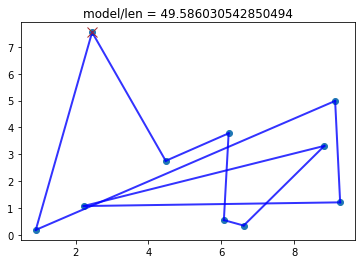

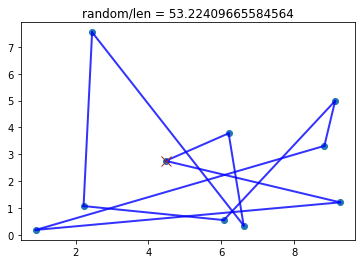

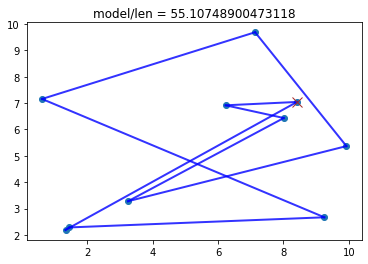

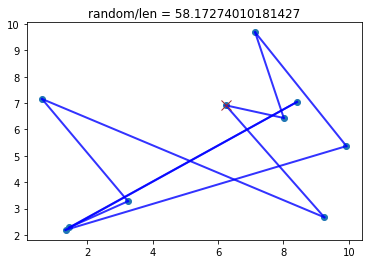

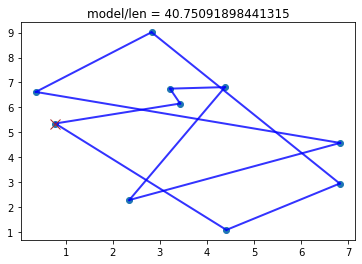

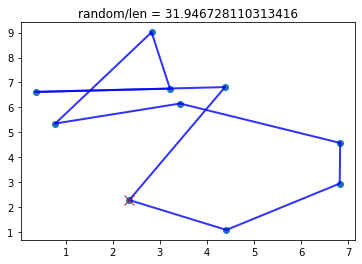

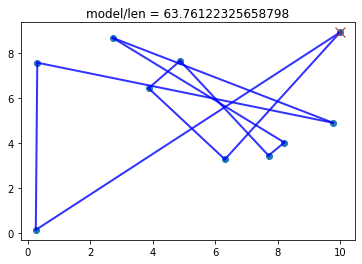

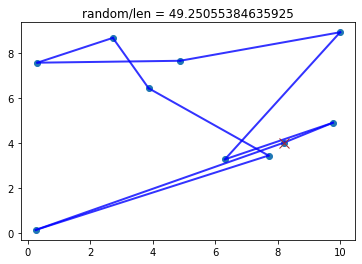

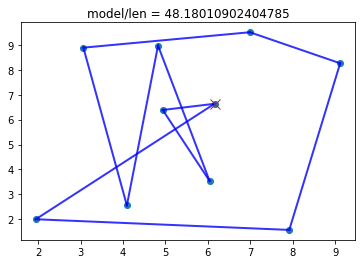

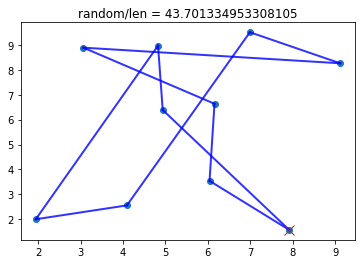

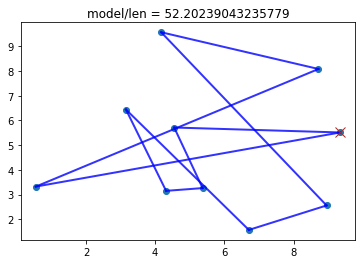

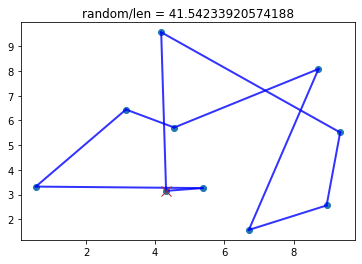

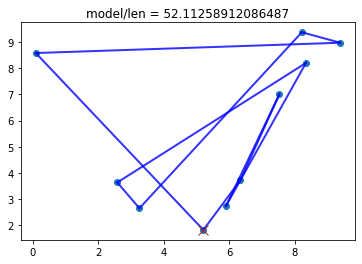

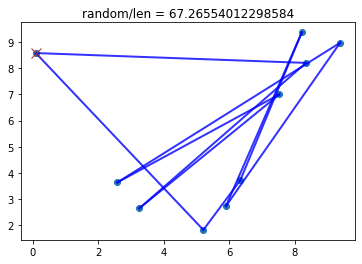

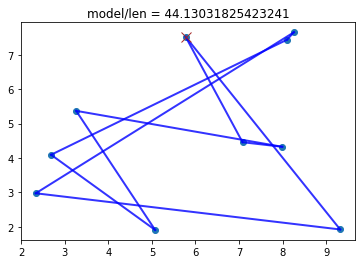

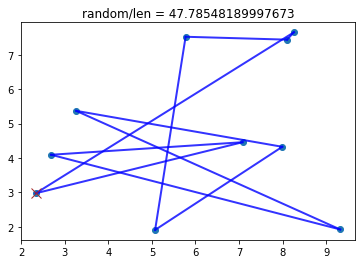

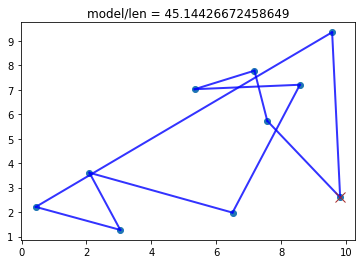

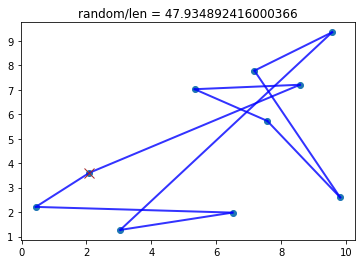

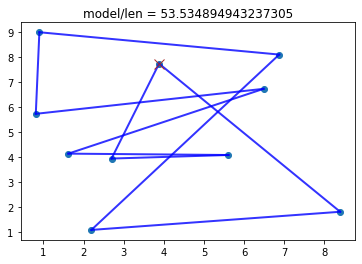

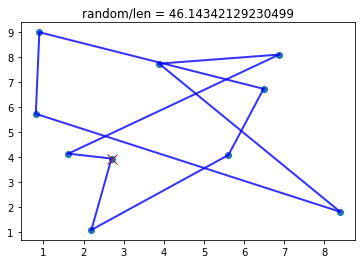

In [0]:
#Generate example solutions
NR_NODES = 10
for sample in range(10):
    coords, W_np = getGraph(n=NR_NODES)

    googleORtools(W_np)
    min_dis, travel_route = nearest_neighbor(W_np)
    print(min_dis)
    print(travel_route)


    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    solution = [random.randint(0, NR_NODES-1)]
    currentState = State(partial_solution=solution, W=W, coords=coords)
    currentStateTsr = state2tens(currentState)
    
    while not checkFinalState(currentState):
        next_node, est_reward = Q_func.bestAction(currentStateTsr, currentState) 
        solution = solution + [next_node]
        currentState = State(partial_solution=solution, W=W, coords=coords)
        currentStateTsr = state2tens(currentState)
    


    plt.figure()
    plot_solution(coords, W, solution)
    plt.title('model/len = {}'.format(totalDistance(solution, W)))

    data = {}
    data['locations'] = W_np
    data['num_vehicles'] = 1
    data['depot'] = 0
        
 # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random/len = {}'.format(totalDistance(random_solution, W)))